In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt

import os
import sys
import logging

In [15]:
adata_infile = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/objects_other/stream_input_filtered_cells_v3.h5ad"
stream_outs_path = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs/new_adata_male_sc_preprocessed'
dictys_data_path = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/data'
barcodes_dir = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/SLIDE_cell_barcodes'

In [16]:
!rsync -aP $adata_infile /dev/shm/

sending incremental file list
stream_input_filtered_cells_v3.h5ad
  2,600,602,645 100%  426.72MB/s    0:00:05 (xfr#1, to-chk=0/1)


# Run stream dim reduction (LLE) on the anndata, with imputed gene expression and filtered cells

In [17]:
from os.path import basename
import stream as st
#read the stream result file pkl
adata = st.read(file_name='/dev/shm/' + os.path.basename(adata_infile), workdir=stream_outs_path)


Saving results in: /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs/new_adata_male_sc_preprocessed


In [18]:
#set the imputed gene expression as the accessible data layer
adata.X = adata.layers['MAGIC_imputed_data']

#### run on all highly_variable imputed genes (4k)

In [19]:
adata

AnnData object with n_obs × n_vars = 23211 × 4142
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'score_G1S', 'score_G2M', 'score_myc_up', 'score_GC', 'score_PB', 'score_MBC_1', 'score_MBC_2', 'score_preGC', 'score_LZ_GC', 'score_DZ_GC', 'DNA_damage', 'LZ_vs_DZ_down', 'LZ_vs_DZ_up', 'Ag_presentation', 'BCR_signaling', 'topic7_peak_genes', 'isre_topic7_go0050776', 'ap1_topic11_GO_0002757', 'ets_topic15_GO_0022407', 'isre_topic7_great', 'ap1_topic11_great', 'ets_topic15_great', 'irf4_prdm1_upDEG', 'irf4_spib_upDEG', 'irf4_batf_upDEG', 'irf4_prdm1_

3106 variable genes are selected


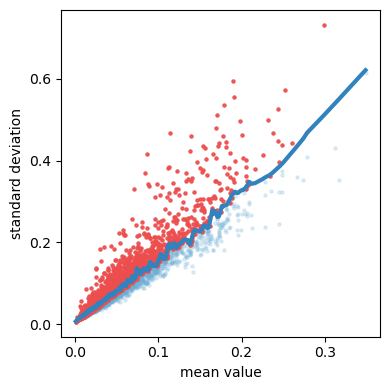

In [20]:
st.select_variable_genes(adata,loess_frac=0.01,percentile=25)

In [21]:
# 'var_genes' vs 'all' uses all the imputed, highly variable genes hence make sure the number of vars are only 3k/4k
st.dimension_reduction(adata,method='se',feature='var_genes',n_components=2,n_neighbors=30,n_jobs=64) # using the same knn as diffusion maps (default is 30)

feature var_genes is being used ...
64 cpus are being used ...


#### Order cell types based on how you think the pseudotime should be

In [22]:
import pandas as pd
adata.obs['leiden'] = pd.Categorical(
    adata.obs['leiden'],
    categories=['earlyActB', 'ActB-2', 'ActB-3', 'ActB-4', 'GC-1', 'GC-2', 'earlyPB', 'PB-2'],
    ordered=True
)

In [23]:
print(adata.obsm.keys())

KeysView(AxisArrays with keys: DM_EigenVectors, X_diffmap, X_draw_graph_fa, X_joint_umap_features, X_pca, X_topic_compositions, X_umap, X_umap_features, var_genes, X_se, X_dr)


In [24]:
print(adata.uns['leiden_colors'])

['dodgerblue' 'mediumorchid' 'limegreen' 'darkblue' 'green' 'firebrick'
 'lightcoral' 'teal']


In [25]:
# Create a custom dictionary mapping sub_cell_types to colors
# color_dict = {
#     '1_ABC': '#FF7F00',    # Orange
#     '2_UD_4': '#006400',   # Dark green
#     '3_GC': '#D62728',     # Red
#     '4_Day 3 cells': '#9467BD',  # Purple
#     '6_MBC from GC': '#E377C2',  # Pink
#     '7_PB': '#808000',     # Olive Green
#     '8_UD_2': '#17BECF',   # Cyan
#     '9_UD_1': '#87CEEB',   # Sky Blue
#     '10_UD_0': '#FFE4B5',  # Very Light Orange
#     '11_UD_3': '#D3D3D3'   # Light Gray
# }
# Create the color dict from the uns storing the colors for the ordered sub_cell_types which are a pd.Categorical object with the ordered categories being the keys and the colors being the values
color_dict = dict(zip(adata.obs['leiden'].cat.categories, adata.uns['leiden_colors']))
# Add a new column to obs with the color for each cell
adata.obs['leiden_colors'] = adata.obs['leiden'].map(color_dict)

# Verify the new column
print(adata.obs[['leiden', 'leiden_colors']].head())

                    leiden leiden_colors
AAACAGCCAAGCCACT-3    GC-1         green
AAACAGCCAAGGTGCA-1  ActB-2  mediumorchid
AAACAGCCATTCAGCA-3    GC-1         green
AAACATGCAAAGCTCC-1  ActB-2  mediumorchid
AAACATGCACACAATT-3    GC-2     firebrick


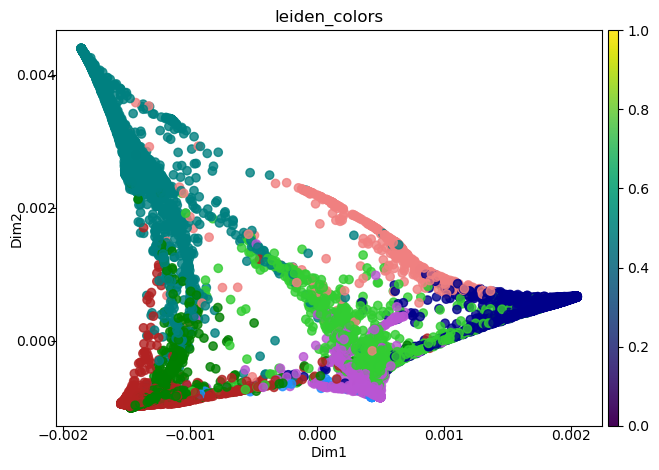

In [26]:
st.plot_dimension_reduction(adata,color=['leiden_colors'],n_components=2)


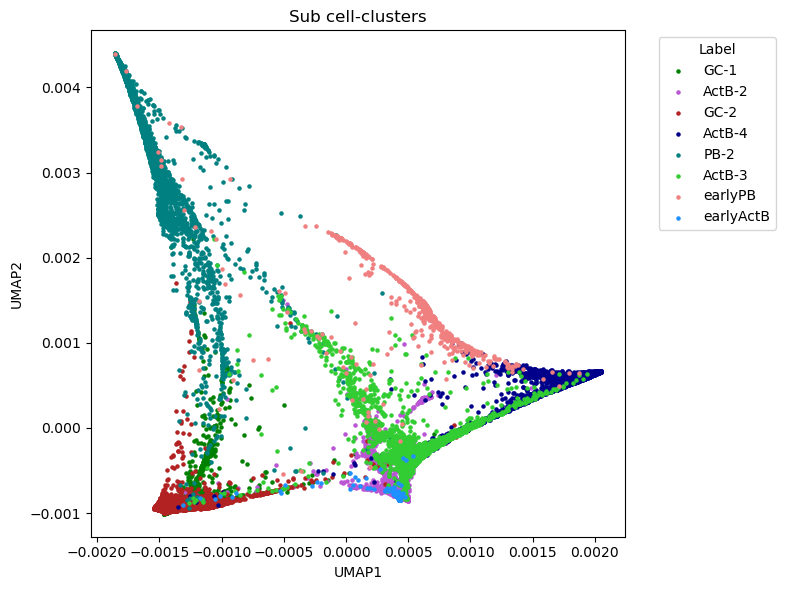

: 

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Extract UMAP coordinates from the 'X_dr' slot 
umap_coords = adata.obsm['X_dr']

# Extract the labels for coloring
labels = adata.obs['leiden']

# Get unique labels and their corresponding colors
unique_labels = labels.unique()
color_list = [color_dict[label] for label in unique_labels]

# Plotting the UMAP with colors based on labels
plt.figure(figsize=(8, 6))

for label, color in zip(unique_labels, color_list):
    idx = labels == label
    plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], c=color, label=label, s=5)  # s=5 sets the marker size to 5 points

plt.title('Sub cell-clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualize selected cells on the trajectory
### Plot days of cells on trajectory embeddings

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract UMAP coordinates from the 'X_dr' slot 
umap_coords = adata.obsm['X_dr']

# Extract the labels for coloring
labels = adata.obs['cell_type_major']

# Get unique labels
unique_labels = labels.unique()

# Define a color for the highlighted cells and for the background cells
highlight_color = '#1f77b4'  # A shade of blue
background_color = '#D3D3D3'  # Light gray

# Create a plot for each unique label
for label in unique_labels:
    plt.figure(figsize=(8, 6))
    
    # Plot background (gray) points first
    plt.scatter(umap_coords[:, 0], umap_coords[:, 1], c=background_color, s=5, alpha=0.5)
    
    # Plot highlighted points
    idx = labels == label
    plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], c=highlight_color, s=5, label=label)

    plt.title(f'UMAP: {label} cells highlighted')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend(title="Highlighted Cells", loc='upper left')
    plt.tight_layout()
    plt.show()

### Plot predicted cells commiting to each state from perturb-seq data and SLIDE analysis

In [ ]:
# load cell barcodes from perturb-seq data and SLIDE analysis
day2_cells = ['D2_per_BATF.csv', 'D2_per_IRF4.csv', 'D2_per_SPIB.csv', 'D2_per_PRDM1.csv', 'D2_per_IRF8.csv']
day4_cells = ['D4_per_BATF.csv', 'D4_per_IRF4.csv', 'D4_per_SPIB.csv', 'D4_per_PRDM1.csv', 'D4_per_IRF8.csv']   

# Function to read CSV and add perturbation column
def read_csv_with_perturbation(filename):
    df = pd.read_csv(os.path.join(barcodes_dir, filename))
    perturbation = filename.split('.')[0]  # Remove .csv
    df['Perturbation'] = perturbation
    return df

# Read and combine day2 cells
day2_cells_df = pd.concat([read_csv_with_perturbation(file) for file in day2_cells], ignore_index=True)
day4_cells_df = pd.concat([read_csv_with_perturbation(file) for file in day4_cells], ignore_index=True)

# Rename the first column to 'Barcode'
day2_cells_df = day2_cells_df.rename(columns={day2_cells_df.columns[0]: 'Barcode'})
day4_cells_df = day4_cells_df.rename(columns={day4_cells_df.columns[0]: 'Barcode'})

display(day2_cells_df)
display(day4_cells_df)

In [ ]:
# add 10 new fields to adata.obs named the Perturbation names and set them as categorical
day2_perturbations = day2_cells_df['Perturbation'].unique()
day4_perturbations = day4_cells_df['Perturbation'].unique()
all_perturbations = np.concatenate([day2_perturbations, day4_perturbations])

# Create a dictionary for each perturbation mapping barcodes to perturbation names
perturbation_maps = {}
for pert in day2_perturbations:
    barcodes = day2_cells_df[day2_cells_df['Perturbation'] == pert]['Barcode']
    perturbation_maps[pert] = dict.fromkeys(barcodes, pert)
    
for pert in day4_perturbations:
    barcodes = day4_cells_df[day4_cells_df['Perturbation'] == pert]['Barcode']
    perturbation_maps[pert] = dict.fromkeys(barcodes, pert)

# Add a column for each perturbation
for pert in all_perturbations:
    adata.obs[pert] = adata.obs.index.map(perturbation_maps[pert])
    # Convert to categorical with NA for missing values
    adata.obs[pert] = adata.obs[pert].astype('category')

# Verify the results
print("\nSample of cells with their perturbation assignments:")
display(adata.obs[all_perturbations].head())

# Print some statistics
print("\nNumber of cells assigned to each perturbation:")
for pert in all_perturbations:
    n_cells = adata.obs[pert].notna().sum()
    print(f"{pert}: {n_cells} cells")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract UMAP coordinates from the 'X_dr' slot 
umap_coords = adata.obsm['X_dr']

# Separate day2 and day4 perturbations
day2_perturbations = [pert for pert in all_perturbations if pert.startswith('D2_')]
day4_perturbations = [pert for pert in all_perturbations if pert.startswith('D4_')]

# Define colors
highlight_color = '#1f77b4'  # A shade of blue
background_color = '#D3D3D3'  # Light gray

# Create plots for Day 2 perturbations
plt.figure(figsize=(20, 12))
for i, pert in enumerate(day2_perturbations, 1):
    plt.subplot(2, 3, i)
    
    # Plot background (gray) points first
    plt.scatter(umap_coords[:, 0], umap_coords[:, 1], 
               c=background_color, s=5, alpha=0.5)
    
    # Plot highlighted points (cells with non-NA values for this perturbation)
    idx = adata.obs[pert].notna()
    plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], 
               c=highlight_color, s=5, label=pert)

    plt.title(f'UMAP: {pert} cells')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend(title="Highlighted Cells", loc='upper left')

plt.suptitle('Day 2 Perturbations', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Create plots for Day 4 perturbations
plt.figure(figsize=(20, 12))
for i, pert in enumerate(day4_perturbations, 1):
    plt.subplot(2, 3, i)
    
    # Plot background (gray) points first
    plt.scatter(umap_coords[:, 0], umap_coords[:, 1], 
               c=background_color, s=5, alpha=0.5)
    
    # Plot highlighted points (cells with non-NA values for this perturbation)
    idx = adata.obs[pert].notna()
    plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], 
               c=highlight_color, s=5, label=pert)

    plt.title(f'UMAP: {pert} cells')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend(title="Highlighted Cells", loc='upper left')

plt.suptitle('Day 4 Perturbations', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Print statistics
print("\nNumber of cells in each perturbation:")
for pert in all_perturbations:
    n_cells = adata.obs[pert].notna().sum()
    print(f"{pert}: {n_cells} cells")

## Trajectory inference by fitting elastic graph

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "64"
from tempfile import TemporaryDirectory
from rpy2.robjects import r
# Load the rlang package in R
r('library(rlang)')

# Parameters for STREAM (tune to your dataset)
ka1={'epg_alpha':0.02,'epg_mu':0.07,'epg_lambda':0.02,'epg_trimmingradius':2} # epg_mu needs to be tuned to get a good branch for day-1 to activated and undefined cells
ka2={'epg_ext_mode':'QuantDists','epg_ext_par':1.}

# Trajectory inference
with TemporaryDirectory() as td:
	st.set_workdir(adata,td)
	st.seed_elastic_principal_graph(adata,n_clusters=10)
	st.elastic_principal_graph(adata,**ka1)
	st.extend_elastic_principal_graph(adata,**ka2)
	

In [ ]:
st.optimize_branching(adata,incr_n_nodes=30) #smoothen out the branches

In [ ]:
st.plot_branches(adata,show_text=True)

In [ ]:
import matplotlib.pyplot as plt

st.plot_dimension_reduction(adata,show_graph=True,show_text=True,color=['leiden_colors'])
ax=plt.gca()
ax.set_aspect(1)
ax.axis('off');


In [ ]:
###Extend leaf branch to reach further cells 
st.extend_elastic_principal_graph(adata, epg_ext_mode='WeigthedCentroid',epg_ext_par=0.8)
st.plot_dimension_reduction(adata,color=['leiden_colors'],n_components=2,show_graph=True,show_text=True)
st.plot_branches(adata,show_text=True)

In [ ]:
#Replace S3 with your own starting node if on a different dataset
st.plot_dimension_reduction(adata,color=['S2_pseudotime','branch_id_alias'])


In [ ]:
st.plot_flat_tree(adata,color=['leiden_colors','S2_pseudotime','branch_id_alias'],
                  dist_scale=0.5,show_graph=True,show_text=True)


### Verifying genes of interest's expression per branch on the trajectory

In [ ]:
st.plot_stream_sc(adata,root='S2',color=['BATF','IRF4', 'SPIB', 'BCL6', 'IRF8', 'PRDM1'], vmin=0, vmax=1.5,dist_scale=0.3,show_graph=True,show_text=True)

In [ ]:
adata.obs.head()

In [ ]:
# save the S2_pseudotime with barcodes (taken from obs.index) to a csv
pseudotime_df = pd.DataFrame({'Barcode': adata.obs.index, 'S2_pseudotime': adata.obs['S2_pseudotime']})
pseudotime_df.to_csv(os.path.join(stream_outs_path,'S2_pseudotime.csv'), index=False)


In [ ]:
# write stream result to pkl
st.write(adata,file_name=os.path.join(stream_outs_path,'stream_traj_no_pca.pkl'))

In [ ]:
import numpy as np
import pandas as pd
# Extract node names from pseudotime columns
dimnodes=np.array(sorted([x[:-len('_pseudotime')] for x in adata.obs.columns if x.endswith('_pseudotime')]))
dist=np.array([adata.obs.loc[adata.obs.index,x+'_pseudotime'].values for x in dimnodes]).T
node_dict=dict(zip(dimnodes,range(len(dimnodes))))
branch = np.array([
    sorted([node_dict.get(y.strip('() \''), None) for y in x])
    for x in adata.obs['branch_id_alias']
])

# save the branch, edge, and dist files

# The branch each cell is on (cell:(node_start,node_end))
branch=pd.DataFrame(branch,index=adata.obs.index)
branch.to_csv(os.path.join(stream_outs_path,'branch.tsv.gz'),header=False,index=False,sep='\t')

# Identify and save unique edges between nodes
edge=np.unique(branch.values,axis=0)
edge=pd.DataFrame(edge)
edge.to_csv(os.path.join(stream_outs_path,'edge.tsv.gz'),header=False,index=False,sep='\t')

# The distance of each cell to each node (cell:node, value is pseudotime distance)
dist=pd.DataFrame(dist,index=adata.obs.index,columns=dimnodes)
dist.to_csv(os.path.join(stream_outs_path,'dist.tsv.gz'),header=True,index=True,sep='\t')

#### Make subsets of the sub cell types

In [ ]:
adata.obs.leiden.to_csv(f'{dictys_data_path}/clusters.csv',header=['Cluster'],index=True,index_label='Barcode')


#### Make coord_rna.tsv.gz file of the cells and their lower dim coords, for dictys input

In [ ]:
import anndata as ad
import pandas as pd

# Convert the obs.index (cell barcodes) to a DataFrame
obs_index_df = pd.DataFrame(adata.obs.index)
# Create a new AnnData object with only the cell barcodes and X_dr from obsm
adata_reduced = ad.AnnData(
    obs=obs_index_df,  # Use the cell barcodes as the obs DataFrame
    obsm={"X_dr": adata.obsm['X_dr']}  # Keep only 'X_dr' from obsm
)
# Confirm that the new AnnData object has the correct structure
adata_reduced

In [ ]:
import os
import pandas as pd

# Extract the relevant columns from the AnnData object
# The cell barcodes (obs.index) and 'X_dr' from obsm
cell_barcodes = adata.obs.index
xy_coords = adata_reduced.obsm['X_dr']

# Create a DataFrame with cell barcodes as the first column and 'X_dr' as the next columns
coord_df_b_cell = pd.DataFrame(data=xy_coords, columns=['x', 'y'])
coord_df_b_cell.insert(0, None, cell_barcodes)

#display the df
print(coord_df_b_cell.head())

In [ ]:
# Save the DataFrame to a TSV file
output_path = os.path.join(dictys_data_path,'coord_rna.tsv.gz')
coord_df_b_cell.to_csv(output_path, sep='\t', compression='gzip', index=False, header=['', 'x', 'y'])